# How to speed up Python using Cython and Pythran

Python is great, because it's easy to program and a lot of advanced functionality is either build in or is available through modules. However, sometimes it is really just too slow. 

Here we are going to look at how to use two extensions to Python, which compile python code to C or C++ to greatly speed up your python code.

* Pythran https://github.com/serge-sans-paille/pythran
* Cython https://cython.org/

Go to https://python4photonics.org/ to get the notebook

## The test function

To demonstrate the speed-ups one can achieve we are going to look at a typical DSP function: making symbol decisions.

### The function requirements

For each symbol in a (noisy) input signal array find the nearest symbol from a given alphabet, using eucledian distance.

Input Parameters:
* input signal array
* input alphabet array

Output parameters:
* output signal with the same shape as the input signal composed of symbols from the alphabet

## Timing

We are going to use the `timeit` magic function in jupyter for timing our efforst, in more complex code you might want to use a profiler instead

### Generate test data

Lets start of with some easy test data so we now that everything works

In [4]:
# import the base modules we will use

%pylab inline
import numpy as np
from qampy import signals, impairments # convenient way of quickly generating a signals and symbol arrays

Populating the interactive namespace from numpy and matplotlib


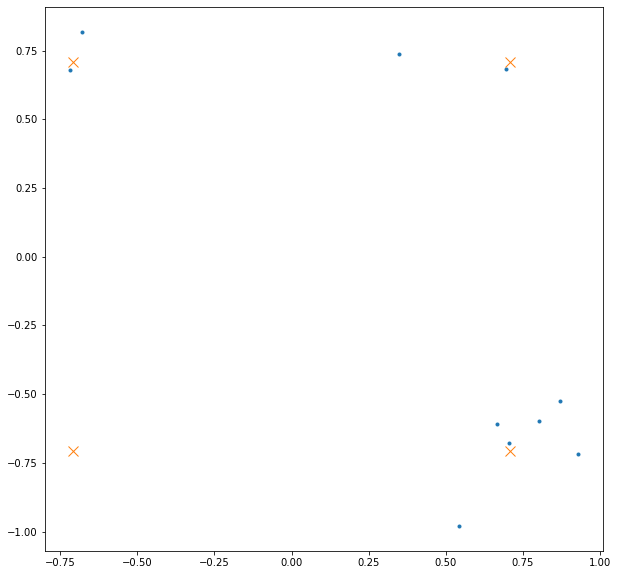

In [5]:
# generate a signal array with some added noise
qpsk = signals.SignalQAMGrayCoded(4, 10, nmodes=1) # generate a single polarization QPSK signal with 100 samples)
qpsk = impairments.change_snr(qpsk, 15) # change the SNR of the signal to 15dB
plt.figure(figsize=(10,10))
plt.plot(qpsk[0].real, qpsk[0].imag, '.') # plot the constellation
plt.plot(qpsk.coded_symbols.real, qpsk.coded_symbols.imag, 'x', ms=10) # plot the alphabet on top

## Naive Python implementation

Let us start of by implementing a naive Python implementation

In [6]:
def make_decision_py(signal, alphabet):
    out = np.zeros_like(signal)
    for i in range(signal.size): # we only do 1D here
        dmin = 1000
        for j in range(alphabet.size):
            d = abs(signal[i]-alphabet[j])
            if d < dmin:
                idx = j
                dmin = d
        out[i] = alphabet[idx]
    return out

Test that it works

In [7]:
out = make_decision_py(qpsk[0], qpsk.coded_symbols)
print(out)
print(qpsk.symbols[0]) # these are the transmitted symbols
print(qpsk.symbols[0]==out)

[ 0.70710678-0.70710678j  0.70710678-0.70710678j -0.70710678+0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678+0.70710678j
  0.70710678+0.70710678j  0.70710678-0.70710678j  0.70710678-0.70710678j
  0.70710678-0.70710678j]
[ 0.70710678-0.70710678j  0.70710678-0.70710678j -0.70710678+0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678+0.70710678j
  0.70710678+0.70710678j  0.70710678-0.70710678j  0.70710678-0.70710678j
  0.70710678-0.70710678j]
[ True  True  True  True  True  True  True  True  True  True]


### Time the code

Lets do some timing of the code

In [8]:
%timeit make_decision_py(qpsk[0], qpsk.coded_symbols)

56.8 µs ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


That is still reasonably fast, but it is a very short array and only QPSK let us have a look at some more realistic data

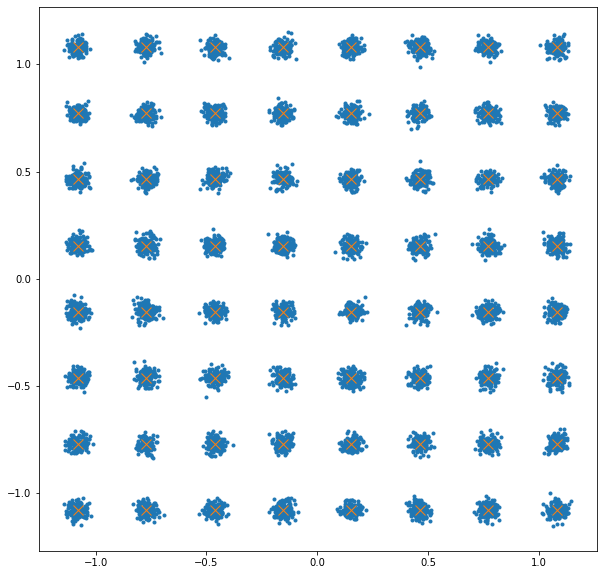

In [9]:
# generate a signal array with some added noise
qam64 = signals.SignalQAMGrayCoded(64, 10**4, nmodes=1) # generate a single polarization 128-QAM signal with 10 000 samples)
qam64 = impairments.change_snr(qam64, 30) # change the SNR of the signal to 30dB
plt.figure(figsize=(10,10))
plt.plot(qam64[0].real, qam64[0].imag, '.') # plot the constellation
plt.plot(qam64.coded_symbols.real, qam64.coded_symbols.imag, 'x', ms=10) # plot the alphabet on top

In [10]:
%timeit make_decision_py(qam64[0], qam64.coded_symbols)

401 ms ± 4.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That is a lot slower and still quite a short array!

## Numpy Implementation

Generally you should always use the numpy vector functions if you can because they will give you a significant speedup. So let us do that

In [11]:
def make_decision_np(signal, alphabet):
    out = np.zeros_like(signal)
    d = np.abs(signal[np.newaxis,:]-alphabet[:, np.newaxis])
    idx = np.argmin(d, axis=0)
    out = alphabet[idx]
    return out

In [12]:
out = make_decision_np(qpsk[0], qpsk.coded_symbols)
print(out)
print(qpsk.symbols[0]) # these are the transmitted symbols
print(qpsk.symbols[0]==out)

[ 0.70710678-0.70710678j  0.70710678-0.70710678j -0.70710678+0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678+0.70710678j
  0.70710678+0.70710678j  0.70710678-0.70710678j  0.70710678-0.70710678j
  0.70710678-0.70710678j]
[ 0.70710678-0.70710678j  0.70710678-0.70710678j -0.70710678+0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678+0.70710678j
  0.70710678+0.70710678j  0.70710678-0.70710678j  0.70710678-0.70710678j
  0.70710678-0.70710678j]
[ True  True  True  True  True  True  True  True  True  True]


In [13]:
%timeit make_decision_np(qam64[0], qam64.coded_symbols)

14 ms ± 94.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That is a factor of 20 faster!

## Speeding up

OK let's try to speed up this code some more

I will use two packages here 

**Cython**

Cython is an optimising static compiler for both the Python programming language and the extended Cython programming language. 
It essentially allows you to write modules in an extended Python dialect that can be compile directly to C and provide significant speed-ups by avoiding most of the Python overheads. Cython has been around for a long time, so it is realtively mature. It is also great for wrapping C-libraries for use with Python.

**Pythran** 

Pythran is an ahead of time compiler for a subset of the Python language, with a focus on scientific computing. It takes a Python module annotated with a few interface description and turns it into a native Python module with the same interface, but (hopefully) faster. Pythran is much younger than Cython, but has been progressing at an impressive pace. 

Both Pythran and Cython can be used directly inside jupyter notebooks which we will use here. However, they are really aimed at being used for compiling modules and that is how I usually use them.

## Cython

Lets start with Python. Our starting point is the Numpy code above

In [15]:
import cython # the cython module
%load_ext cython

In [16]:
%%cython 
import numpy as np
cimport numpy as np
def make_decision_cy(signal, alphabet):
    out = np.zeros_like(signal)
    d = np.abs(signal[np.newaxis,:]-alphabet[:, np.newaxis])
    idx = np.argmin(d, axis=0)
    out = alphabet[idx]
    return out

In [17]:
%timeit make_decision_cy(qam64[0], qam64.coded_symbols)

14.3 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


OK that was rather dissappointing no speed-up compared to the numpy code. However if we read the [Cython documentation](http://docs.cython.org/en/latest/) we find out that we really should be annotating the code to get significant speed-ups. 

The first thing we can do is turn off several of the checks that Python usually does

In [18]:
%%cython 
import numpy as np
cimport numpy as np
import cython

@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
def make_decision_cy(signal, alphabet):
    out = np.zeros_like(signal)
    d = np.abs(signal[np.newaxis,:]-alphabet[:, np.newaxis])
    idx = np.argmin(d, axis=0)
    out = alphabet[idx]
    return out

In [19]:
%timeit make_decision_cy(qam64[0], qam64.coded_symbols)

14.1 ms ± 96.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So again no increase in speed, but considering the code is compiled what if we add some compiler flags?

In [20]:
%%cython -c=-march=native -c=-O3 -c=-ffast-math -c=-mfpmath=sse -c=-fopenmp
import numpy as np
import numpy as np
cimport numpy as np
import cython

@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
def make_decision_cy(signal, alphabet):
    out = np.zeros_like(signal)
    d = np.abs(signal[np.newaxis,:]-alphabet[:, np.newaxis])
    idx = np.argmin(d, axis=0)
    out = alphabet[idx]
    return out

In [21]:
%timeit make_decision_cy(qam64[0], qam64.coded_symbols)

14 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Again no speed up. But we haven't told cython what numeric types we are dealing with so let us add some type annotations

In [22]:
%%cython -c=-march=native -c=-O3 -c=-ffast-math -c=-mfpmath=sse -c=-fopenmp
import numpy as np
cimport numpy as np
import cython

@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
def make_decision_cy(np.ndarray[ndim=1, dtype=np.complex128_t] signal, np.ndarray[ndim=1, dtype=np.complex128_t] alphabet): # two array type annotations
    cdef double complex[:] out # this is a memoryview which essentially tells cython this is a block of memory similar to the ndarray annotations above
    cdef double[:,:] d
    cdef long[:] idx
    out = np.zeros_like(signal)
    d = np.abs(signal[np.newaxis,:]-alphabet[:, np.newaxis])
    idx = np.argmin(d, axis=0)
    out = alphabet[idx]
    return np.array(out)

In [23]:
timeit make_decision_cy(qam64[0], qam64.coded_symbols)

14.3 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Again no speed improvement. What is going on? 

Let us have a look at the code. Cython provides the `--annotate` argument, which tells us how the code is compiled

In [24]:
%%cython --annotate
import numpy as np
cimport numpy as np
import cython

@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
def make_decision_cy(np.ndarray[ndim=1, dtype=np.complex128_t] signal, np.ndarray[ndim=1, dtype=np.complex128_t] alphabet): # two array type annotations
    cdef double complex[:] out # this is a memoryview which essentially tells cython this is a block of memory similar to the ndarray annotations above
    cdef double[:,:] d
    cdef long[:] idx
    out = np.zeros_like(signal)
    d = np.abs(signal[np.newaxis,:]-alphabet[:, np.newaxis])
    idx = np.argmin(d, axis=0)
    out = alphabet[idx]
    return np.array(out)

Yellow above indicates access to Python internals (which are slow). So there is our reason, we are still just using python (numpy) functions. So to speed this up, we have to exchange the numpy functions with C functions. Maybe it's better if we start from the Python function?

In [25]:
%%cython -c=-march=native -c=-O3 -c=-ffast-math -c=-mfpmath=sse -c=-fopenmp
#-c=-march=native -c=-O3 -c=-ffast-math -c=-mfpmath=sse -c=-fopenmp
import numpy as np
cimport numpy as np
import cython

@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
def make_decision_cy(np.ndarray[ndim=1, dtype=np.complex128_t] signal, np.ndarray[ndim=1, dtype=np.complex128_t] alphabet):
    cdef double complex[:] out
    cdef int i, j, idx, N, M
    cdef double d, dmin
    N = signal.size
    M = alphabet.size
    out = np.zeros_like(signal)
    for i in range(N):
        dmin = 1000.
        idx = 0
        for j in range(M):
            d = abs(signal[i]-alphabet[j])
            if d < dmin:
                idx = j
                dmin = d
        out[i] = idx
    return np.array(out)

In [26]:
timeit make_decision_cy(qam64[0], qam64.coded_symbols)

8.45 ms ± 37.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Finally a speed improvement! Not a lot though. The reason is that we are still calling a Python function inside the loop (`abs`). Let us use the C-function instead

In [34]:
%%cython -c=-march=native -c=-O3 -c=-ffast-math -c=-mfpmath=sse -c=-fopenmp
import numpy as np
cimport numpy as np
cimport cython

cdef extern from "complex.h" nogil:
    double cabs(double complex)

    
@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
def make_decision_cy(double complex[:] signal, double complex[:] alphabet):
    cdef double complex[:] out
    cdef int i, j, idx, N, M
    cdef double d, dmin
    N = signal.size
    M = alphabet.size
    out = np.zeros_like(signal)
    for i in range(N):
        dmin = 1000.
        idx = 0
        for j in range(M):
            d = cabs(signal[i]-alphabet[j])
            if d < dmin:
                idx = j
                dmin = d
        out[i] = idx
    return np.array(out)

In [35]:
timeit make_decision_cy(qam64[0], qam64.coded_symbols)

3.86 ms ± 38.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


OK now we have an interesting speed improvement another factor >10 compared to the numpy code. We can actually get even more by using parallel processing. Cython loops that do not use python code can release the GIL

In [36]:
%%cython -c=-march=native -c=-O3 -c=-ffast-math -c=-mfpmath=sse -c=-fopenmp --link-args=-fopenmp
import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import prange

cdef extern from "complex.h" nogil:
    double cabs(double complex)

    
@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
def make_decision_cy(double complex[:] signal, double complex[:] alphabet):
    cdef double complex[:] out
    cdef int i, j, idx, N, M
    cdef double d, dmin
    N = signal.size
    M = alphabet.size
    out = np.zeros_like(signal)
    for i in prange(N, nogil=True):
        dmin = 1000.
        idx = 0
        for j in range(M):
            d = cabs(signal[i]-alphabet[j])
            if d < dmin:
                idx = j
                dmin = d
        out[i] = idx
    return np.array(out)

In [37]:
timeit make_decision_cy(qam64[0], qam64.coded_symbols)

1.12 ms ± 77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Another speed up almost a factor of 100 compared to the numpy code! Let us check what the annotated code looks like now

In [38]:
%%cython --annotate
import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import prange

cdef extern from "complex.h" nogil:
    double cabs(double complex)

    
@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
def make_decision_cy(double complex[:] signal, double complex[:] alphabet):
    cdef double complex[:] out
    cdef int i, j, idx, N, M
    cdef double d, dmin
    N = signal.size
    M = alphabet.size
    out = np.zeros_like(signal)
    for i in prange(N, nogil=True):
        dmin = 1000.
        idx = 0
        for j in range(M):
            d = cabs(signal[i]-alphabet[j])
            if d < dmin:
                idx = j
                dmin = d
        out[i] = idx
    return np.array(out)

## Pythran

We could get a speed improvement of a factor of almost 100 over the numpy code using cython. But the code became significantly more complex. Let us look at Pythran now to see what sort of improvements we get with it.

In [39]:
import pythran
%load_ext pythran.magic

### Starting point

We again start from the numpy function. Pythran works a bit differently to Cython. Instead of adding a type annotations to the code we simply use a comment to indicate the types for the parameters.

In [40]:
%%pythran
import numpy as np
#pythran export make_decision_pt(complex128[], complex128[])
def make_decision_pt(signal, alphabet):
    out = np.zeros_like(signal)
    d = np.abs(signal[np.newaxis,:]-alphabet[:, np.newaxis])
    idx = np.argmin(d, axis=0)
    out = alphabet[idx]
    return out

Pythran also allows to add multiple annotations for passing different types

In [41]:
%%pythran
import numpy as np
#pythran export make_decision_pt(complex128[], complex128[])
#pythran export make_decision_pt(complex64[], complex64[])
def make_decision_pt(signal, alphabet):
    out = np.zeros_like(signal)
    d = np.abs(signal[np.newaxis,:]-alphabet[:, np.newaxis])
    idx = np.argmin(d, axis=0)
    out = alphabet[idx]
    return out

In [42]:
%timeit make_decision_pt(qam64[0], qam64.coded_symbols)

3.29 ms ± 40.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
make_decision_pt(qam64[0].astype(np.complex64), qam64.coded_symbols.astype(np.complex64))

array([-0.46291006+1.0801234j , -0.46291006-0.77151674j,
       -0.46291006-0.77151674j, ..., -0.77151674+0.77151674j,
       -0.15430336-0.77151674j, -0.15430336-1.0801234j ], dtype=complex64)

Again not much gain over numpy.

**However** We did not use any compiler optimizations

Try again but use compiler optimizations

In [44]:
%%pythran -O3 -march=native -ffast-math -mfpmath=sse -fopenmp
import numpy as np
#pythran export make_decision_pt(complex128[], complex128[])
def make_decision_pt(signal, alphabet):
    out = np.zeros_like(signal)
    d = np.abs(signal[np.newaxis,:]-alphabet[:, np.newaxis])
    idx = np.argmin(d, axis=0)
    out = alphabet[idx]
    return out

In [45]:
%timeit make_decision_pt(qam64[0], qam64.coded_symbols)

3.16 ms ± 39.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Thats another factor of 10 over the numpy code. Pythran can even use SIMD instructions. Lets see how much difference it makes here

In [46]:
%%pythran -O3 -march=native -ffast-math -mfpmath=sse -fopenmp -DUSE_XSIMD
import numpy as np
#pythran export make_decision_pt(complex128[], complex128[])
def make_decision_pt(signal, alphabet):
    out = np.zeros_like(signal)
    d = np.abs(signal[np.newaxis,:]-alphabet[:, np.newaxis])
    idx = np.argmin(d, axis=0)
    out = alphabet[idx]
    return out

In [47]:
%timeit make_decision_pt(qam64[0], qam64.coded_symbols)

3.26 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's see if we can get some more gains by splitting up the loop like in cython. We can also use openmp (multi-threading) support.

In [48]:
%%pythran -O3 -march=native -ffast-math -mfpmath=sse -fopenmp
import numpy as np
#pythran export make_decision_pt2(complex128[], complex128[])

def make_decision_pt2(signal, alphabet):
    out = np.zeros_like(signal)
    #omp parallel for
    for i in range(signal.size): # we only do 1D here
        dmin = 1000
        idx = 0
        for j in range(alphabet.size):
            d = abs(signal[i]-alphabet[j])
            if d < dmin:
                idx = j
                dmin = d
        out[i] = alphabet[idx]
    return out

In [49]:
%timeit make_decision_pt2(qam64[0], qam64.coded_symbols)

1.07 ms ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Conclusions

Both _cython_ and _pythran_ can yield significant speed improvements over python or even numpy code. The advantage of _cython_ is that it is very generic and can speed up almost any code. Pythran on the other hand is not as general, but geared numerical applications, for this sort of code it can often yield impressive speed gains with very little adjustment to the original code (often only a comment is required).

## Other packages

Another very popular package for speeding up python code is [Numba](http://numba.pydata.org/), which is a just-in-time (JIT) compiler. Numba can also get high speed gains, often very